# Contrails Detection Final Model- 3DUNet++ & Ensamble 

## Data Collection

In [1]:
import os 
import sys 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
# Pytorch module 
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl

import random
from typing import Any, Mapping
from time import gmtime, strftime

# set working directory
os.chdir('/home/jovyan/contrails/contrails_detection/')

# Project Module
import config
import src.utils as utils
from src.dataset import ContrailsDataset, ContrailsDatasetSeqs
from src.model import BaseUnet, SegmentLightning, AttentionUNet, UNetPlus, SegmentLightningTS
from src.train import Trainer
from src.trainer_lgt import TrainerLightning

## Tensorboard Modules
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Memory management
def clear_torch_cache():
    torch.cuda.empty_cache()
    print("Cleared PyTorch GPU cache.")

# Run the function to clear GPU cache
clear_torch_cache()

!nvidia-smi

Cleared PyTorch GPU cache.
Sun Aug 25 19:47:35 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.03   Driver Version: 525.116.03   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:03:00.0 Off |                  Off |
| 77%   83C    P2    66W / 140W |   4678MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                             

In [3]:
## Load file from csv split into train/test
from sklearn.model_selection import train_test_split
df = pd.read_csv(config.CSV_TRAIN_REC, index_col=0)
train_df, valid_df = train_test_split(df[df.Class.isin([0,1])], test_size = .2, random_state=42)
train_df.head()

,Image_ID,Class
16081,8975896718947475053,0
17494,2887461863286016746,0
15040,1323985642378913441,1
7528,8578962451401293377,0
18488,1733973341297589475,1


In [3]:
torch.manual_seed(44)
transform = transforms.Compose([
    # Add your desired transformations here
    #transforms.ToTensor(),
    transforms.Lambda(lambda x: x/256.0),
    transforms.Lambda(utils.get_rgb),
    #transforms.Lambda(lambda x: utils.get_rgb(x)),
    #transforms.Lambda(lambda x: utils.compute_TDi_ashrgb(x, -5)),
                      ])


train_dataset = ContrailsDatasetSeqs(dataframe=train_df,
                                 root_dir=config.DATA_DIR+'train',
                                 transform=transform,
                                )

## Data Loaders
train_dataloader = DataLoader(train_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=config.WORKERS,
                              pin_memory=True,
                              prefetch_factor=config.WORKERS,
                             )

## Validation Dataloader 
valid_dataset = ContrailsDatasetSeqs(dataframe=valid_df,
                                 root_dir=config.DATA_DIR+'train',
                                 transform=transform,
                                )

valid_dataloader = DataLoader(valid_dataset,
                              batch_size=4,
                              shuffle=False,
                              num_workers=config.WORKERS,
                              prefetch_factor=config.WORKERS
                             )

In [4]:
%%time
t_image, t_mask = next(iter(train_dataloader))
print(len(train_dataloader))
t_image.shape, t_mask.shape

4106
CPU times: user 1.81 s, sys: 1.06 s, total: 2.87 s
Wall time: 5.73 s


(torch.Size([4, 3, 8, 256, 256]), torch.Size([4, 1, 256, 256]))

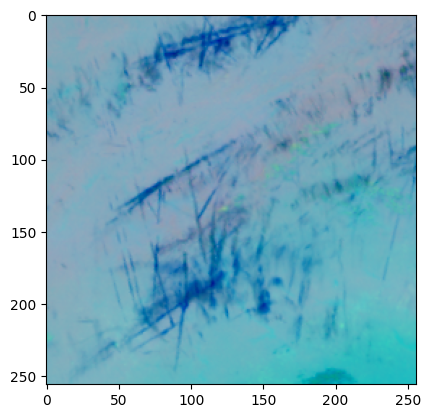

In [5]:
plt.imshow(t_image[0][:, 0, :, :].permute(1,2,0))

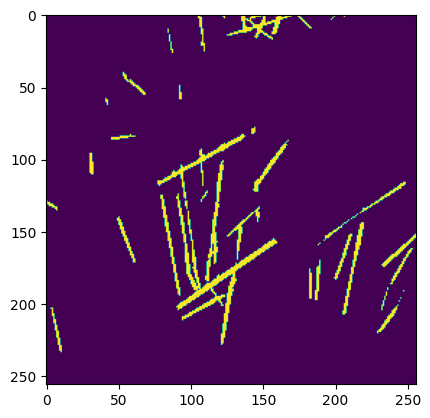

In [6]:
plt.imshow(t_mask[0, 0, :, :])

## 3D Unet++

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv3D(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv3D, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet3DPlusPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet3DPlusPlus, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        
        # Pooling layer with stride of 1 in the depth dimension to prevent collapse
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2), padding=(0, 0, 0))

        # Down part of U-Net++
        for feature in features:
            self.downs.append(DoubleConv3D(in_channels, feature))
            in_channels = feature

        # Up part of U-Net++
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose3d(
                    feature * 2, feature, kernel_size=2, stride=(1, 2, 2),
                )
            )
            self.ups.append(DoubleConv3D(feature * 2, feature))

        self.bottleneck = DoubleConv3D(features[-1], features[-1] * 2)
        
        # Final 2D convolution to collapse the depth dimension
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        # Collapse the depth dimension and apply the final 2D convolution
        x = x.mean(dim=2)  # Average over the depth dimension
        return self.final_conv(x)

In [26]:
unet3d_model = UNet3DPlusPlus(in_channels=3, out_channels=1)
output = unet3d_model(_image)
output.shape

NameError: name 't_image' is not defined

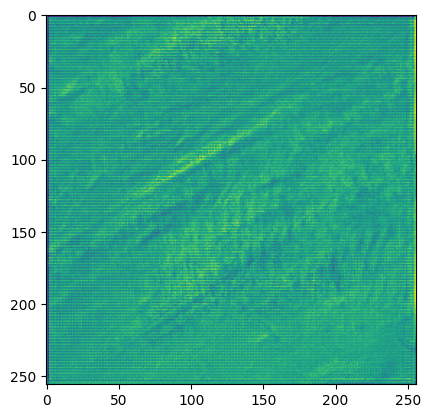

In [10]:
plt.imshow(output[0, 0,:, :].detach().numpy())

In [15]:
main_model = unet3d_model.to(config.DEVICE)

_expr_name = "3DUNetPlus_Final_v1"
tb_path = "tb_log/O3_TS"
logger = pl.loggers.TensorBoardLogger(tb_path, name=_expr_name)
logger

In [21]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, tversky_weight=0.6, bce_weight=0.4):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.tversky_weight = tversky_weight
        self.bce_weight = bce_weight
        self.tversky_loss = TverskyLoss(alpha=alpha, beta=beta)
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        tversky = self.tversky_loss(inputs, targets)
        bce = self.bce_loss(inputs, targets)
        combined_loss = self.tversky_weight * tversky + self.bce_weight * bce
        return combined_loss

class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, smooth=1):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        true_pos = torch.sum(targets * inputs)
        false_neg = torch.sum(targets * (1 - inputs))
        false_pos = torch.sum((1 - targets) * inputs)
        tversky = (true_pos + self.smooth) / (true_pos + self.alpha * false_neg + self.beta * false_pos + self.smooth)
        return 1 - tversky

In [17]:
# Criterion
criterion = CombinedLoss()

# Gradient clipping
torch.nn.utils.clip_grad_norm_(main_model.parameters(), max_norm=1.0)

# Scheduler
scheduler_name = 'ReduceLROnPlateau'
scheduler_params = {'factor': 0.1, 'patience': 3, 'min_lr': 1e-6}

# Training Model
lgt_O3model = SegmentLightningTS(
            model=main_model,
            criterion=criterion,
            learning_rate=1e-5,
            scheduler_name=scheduler_name,
            scheduler_params=scheduler_params,
            train_dataset=train_dataset,
            val_dataset=valid_dataset,
            batch_size=4
        )

In [18]:
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=f'./model_checkpoints/OBJ3/' + _expr_name,
            monitor="val_loss",
            save_last=True,
            save_top_k=5
        )

# Trainer
trainer = pl.Trainer(
            max_epochs=100,
            logger=logger,
            precision=config.PRECISION,
            accelerator=config.ACCELERATOR,
            devices=[0],
            min_epochs=1,
            callbacks=[checkpoint_callback, early_stop_callback],
        )

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
torch.cuda.empty_cache()
trainer.fit(lgt_O3model)

Missing logger folder: tb_log/O3_TS/3DUNetPlus_Final_v1
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type           | Params
----------------------------------------------------
0 | model            | UNet3DPlusPlus | 90.3 M
1 | criterion        | CombinedLoss   | 0     
2 | dice_coefficient | Dice           | 0     
----------------------------------------------------
90.3 M    Trainable params
0         Non-trainable params
90.3 M    Total params
180.616   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Ensamble Model

### Single-frame model loading

In [18]:
## Data collection for single frame
torch.manual_seed(44)
transform = transforms.Compose([
    # Add your desired transformations here
    transforms.ToTensor(),
    transforms.Lambda(lambda x: utils.compute_TDi_ashrgb(x, -5)),
                      ])


sf_train_dataset = ContrailsDataset(dataframe=train_df,
                                 root_dir=config.DATA_DIR+'train',
                                 transform=transform,
                                 sequence_index=config.TS # nth:5 sequence image
                                )

## Data Loaders
sf_train_dataloader = DataLoader(sf_train_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=config.WORKERS,
                              pin_memory=True,
                              prefetch_factor=config.WORKERS,
                             )

## Validation Dataloader 
sf_valid_dataset = ContrailsDataset(dataframe=valid_df,
                                 root_dir=config.DATA_DIR+'train',
                                 transform=transform,
                                 sequence_index=config.TS
                                )

sf_valid_dataloader = DataLoader(sf_valid_dataset,
                              batch_size=4,
                              shuffle=False,
                              num_workers=config.WORKERS,
                              prefetch_factor=config.WORKERS
                             )


In [19]:
%%time
sf_image, sf_mask = next(iter(sf_train_dataloader))
sf_image.shape, sf_mask.shape

CPU times: user 48.3 ms, sys: 633 ms, total: 682 ms
Wall time: 1.09 s


(torch.Size([4, 5, 256, 256]), torch.Size([4, 1, 256, 256]))

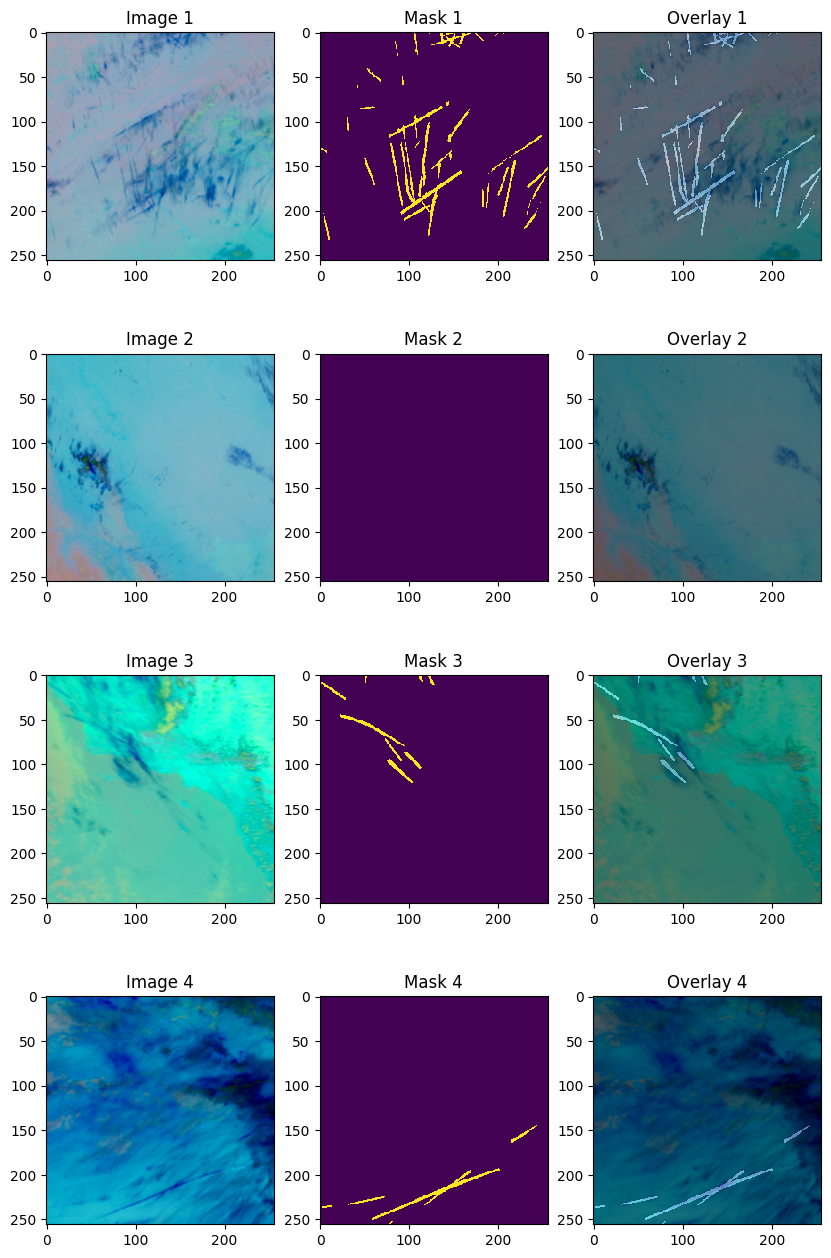

In [7]:
utils.plot_image_and_mask(sf_image, sf_mask)

In [11]:
! ls model_checkpoints/OBJ2_FINAL/UNetPlus_Gauss_Tune

'epoch=32-step=67749.ckpt'  'epoch=40-step=84173.ckpt'
'epoch=33-step=69802.ckpt'  'epoch=45-step=94438.ckpt'
'epoch=37-step=78014.ckpt'   last.ckpt


In [15]:
# Load saved model from directory
model_chkp = "model_checkpoints/OBJ2_FINAL/UNetPlus_Gauss_Tune/"
MODEL_PKL = "epoch=45-step=94438.ckpt"
model_checkpoint_path = model_chkp + MODEL_PKL
checkpoint = torch.load(model_checkpoint_path)

# Extract the state_dict from the checkpoint
saved_state_dict = checkpoint['state_dict']
prefix = "model."  # Adjust the prefix as needed
filtered_state_dict = {k[len(prefix):]: v for k, v in saved_state_dict.items() if k.startswith(prefix)}

In [16]:
# Load model
IN=5
FEATURE=[64, 128, 256, 512]
sf_model = UNetPlus(in_channels=IN, out_channels=1, features=FEATURE)
sf_model.load_state_dict(filtered_state_dict)
sf_model.eval()

UNetPlus(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout2d(p=0.0, inplace=False)
        (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU(inplace=True)
        (7): Dropout2d(p=0.0, inplace=False)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        

In [15]:
%%time
sf_model = sf_model.to(config.DEVICE)
data = sf_image.to(config.DEVICE)
sf_prediction = torch.sigmoid(sf_model(data))

In [16]:
sf_prediction.shape

torch.Size([4, 1, 256, 256])

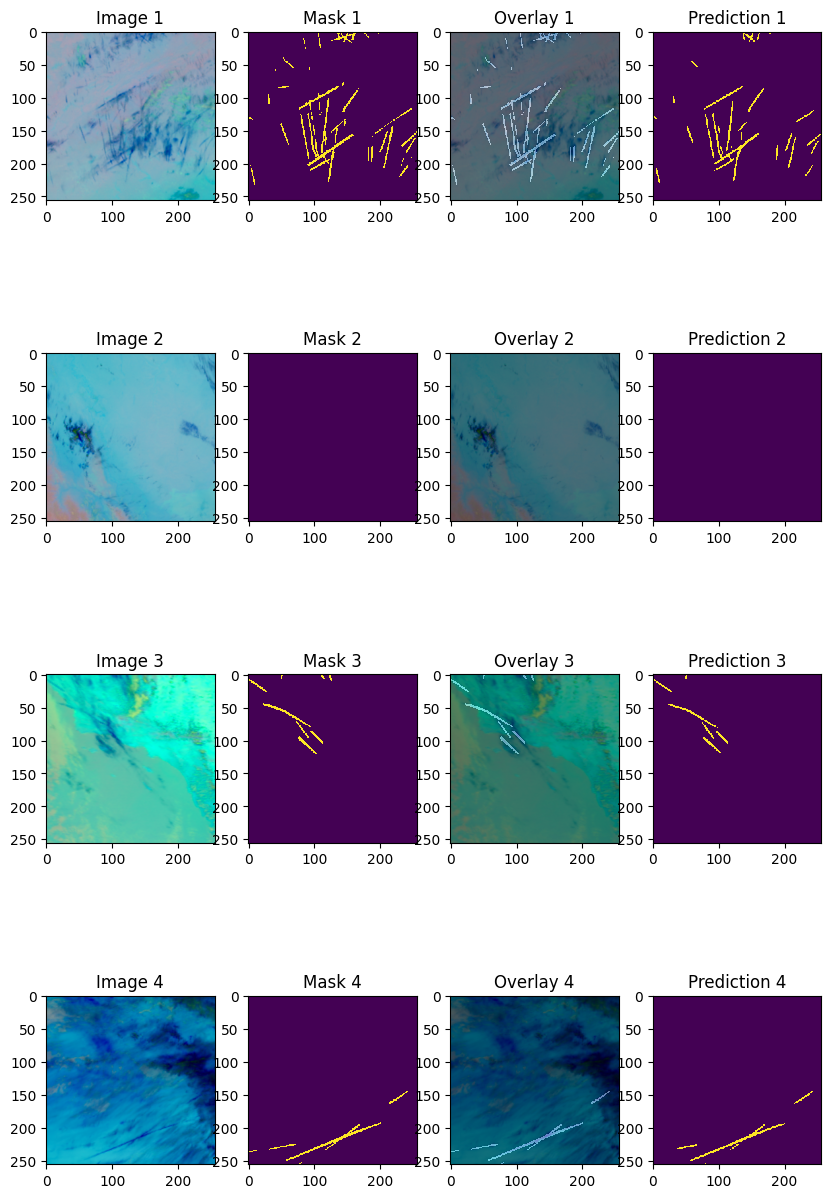

In [23]:
utils.plot_image_and_mask(sf_image, sf_mask, sf_prediction.detach()>0.35)

### Multiframe-3D Model

In [5]:
## Data Collection
torch.manual_seed(44)
transform = transforms.Compose([
    # Add your desired transformations here
    #transforms.ToTensor(),
    transforms.Lambda(lambda x: x/256.0),
    transforms.Lambda(utils.get_rgb),
                      ])


mf_train_dataset = ContrailsDatasetSeqs(dataframe=train_df,
                                 root_dir=config.DATA_DIR+'train',
                                 transform=transform,
                                )

## Data Loaders
mf_train_dataloader = DataLoader(mf_train_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=config.WORKERS,
                              pin_memory=True,
                              prefetch_factor=config.WORKERS,
                             )

## Validation Dataloader 
mf_valid_dataset = ContrailsDatasetSeqs(dataframe=valid_df,
                                 root_dir=config.DATA_DIR+'train',
                                 transform=transform,
                                )

valid_dataloader = DataLoader(mf_valid_dataset,
                              batch_size=4,
                              shuffle=False,
                              num_workers=config.WORKERS,
                              prefetch_factor=config.WORKERS
                             )

In [8]:
!nvidia-smi

Sun Aug 25 19:48:08 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.03   Driver Version: 525.116.03   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:03:00.0 Off |                  Off |
| 75%   90C    P2   131W / 140W |   5358MiB / 16376MiB |     67%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
mf_image, mf_mask = next(iter(mf_train_dataloader))
mf_image.shape, mf_mask.shape

(torch.Size([4, 3, 8, 256, 256]), torch.Size([4, 1, 256, 256]))

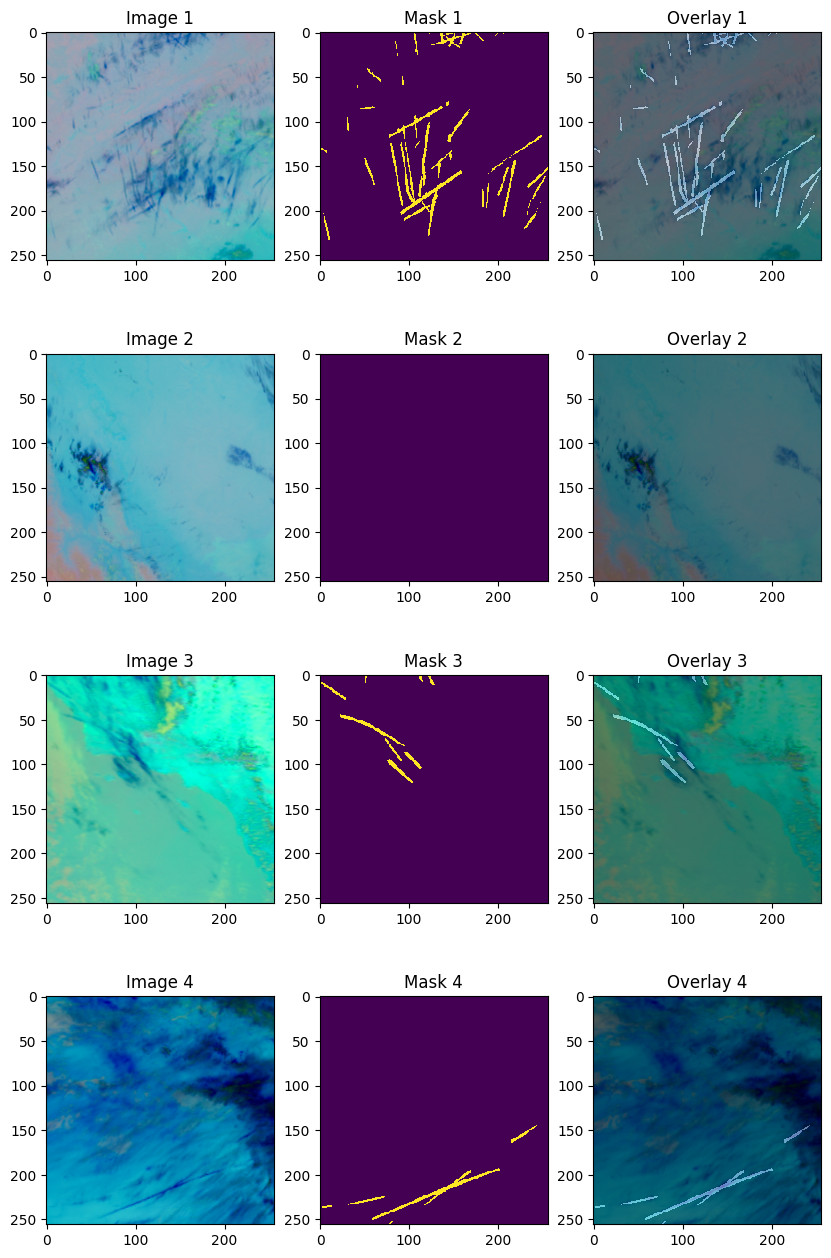

In [8]:
utils.plot_image_and_mask(mf_image[:,:,4, :,:], mf_mask)

In [9]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

In [10]:
%%time
# Load saved model from directory
model_chkp = "model_checkpoints/OBJ3/3DUNetPlus_Final_v1/"
MODEL_PKL = "epoch=24-step=102650.ckpt"
model_checkpoint_path = model_chkp + MODEL_PKL
checkpoint = torch.load(model_checkpoint_path)

# Extract the state_dict from the checkpoint
saved_state_dict = checkpoint['state_dict']
prefix = "model."  # Adjust the prefix as needed
filtered_state_dict = {k[len(prefix):]: v for k, v in saved_state_dict.items() if k.startswith(prefix)}
mf_model = UNet3DPlusPlus(in_channels=3, out_channels=1)
mf_model.load_state_dict(filtered_state_dict)
mf_model.eval()
mf_model = mf_model.to(config.DEVICE)

# Perform inference with torch.no_grad() to reduce memory usage
with torch.no_grad():
    data = mf_image.to(config.DEVICE)
    mf_prediction = torch.sigmoid(mf_model(data))

CPU times: user 4.55 s, sys: 1.91 s, total: 6.46 s
Wall time: 6.46 s


In [11]:
!nvidia-smi

Sun Aug 25 19:48:59 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.03   Driver Version: 525.116.03   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:03:00.0 Off |                  Off |
| 75%   91C    P2   136W / 140W |  13210MiB / 16376MiB |     81%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
mf_prediction.shape

torch.Size([4, 1, 256, 256])

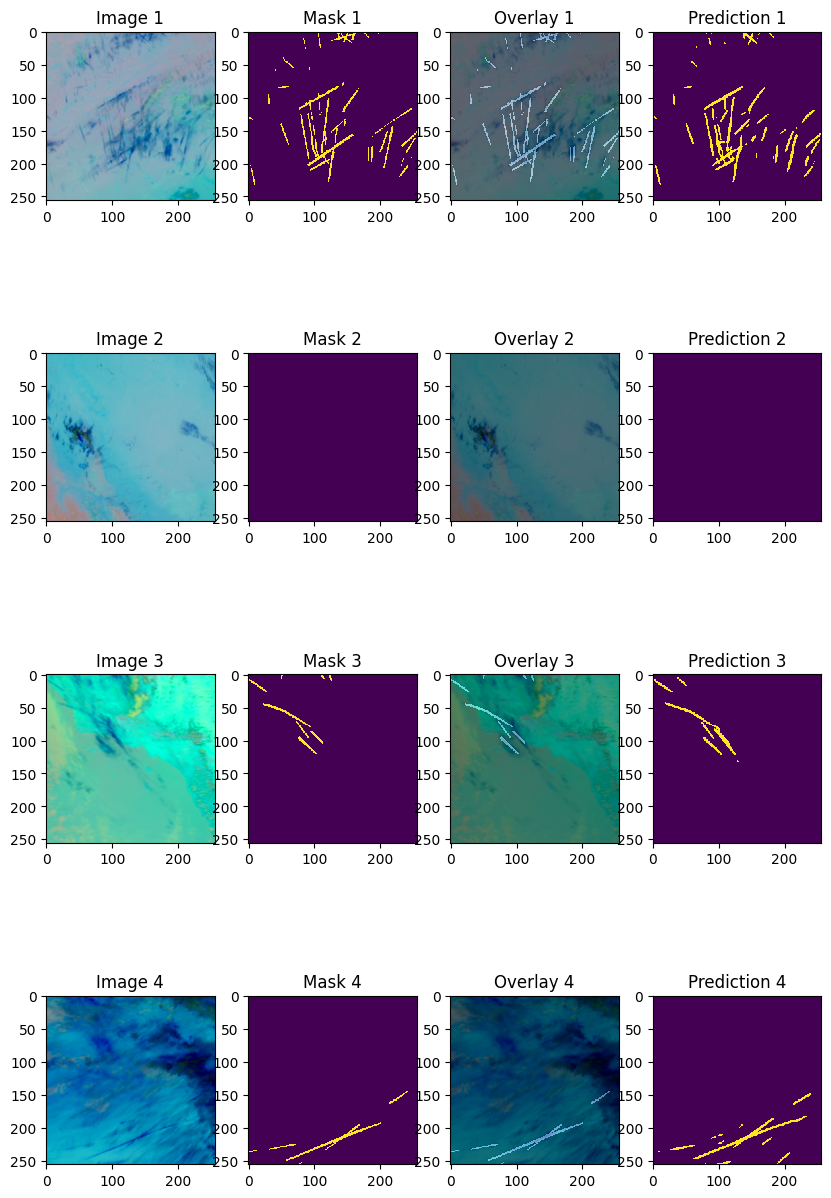

In [13]:
utils.plot_image_and_mask(mf_image[:,:,4, :,:], mf_mask, mf_prediction>0.35)

In [20]:
class EnsembleModel(nn.Module):
    def __init__(self, sf_model, mf_model):
        super(EnsembleModel, self).__init__()
        self.sf_model = sf_model  # Single Frame U-Net+ model
        self.mf_model = mf_model  # Multi-Frame 3D U-Net++ model
        
        # Assuming both models output a feature map with the same spatial dimensions
        # Define a fusion layer to combine features from both models
        self.fusion_conv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=1)

    def forward(self, x_sf, x_mf):
        # x_sf is of shape (batch_size, 5, H, W) for Single Frame model
        # x_mf is of shape (batch_size, 3, sequence_length, H, W) for Multi-Frame model

        # Extract features from the Single Frame model
        sf_features = self.sf_model(x_sf)  # (batch_size, 1, H, W)

        # Extract features from the Multi-Frame 3D U-Net++ model
        mf_features = self.mf_model(x_mf)  # (batch_size, 1, H, W)

        # Concatenate the features along the channel dimension
        combined_features = torch.cat((sf_features, mf_features), dim=1)  # (batch_size, 2, H, W)

        # Apply fusion conv layer to combine the features
        output = self.fusion_conv(combined_features)  # (batch_size, 1, H, W)

        return output

# Load the pre-trained models
sf_model.eval()  # Ensure the models are in evaluation mode
mf_model.eval()

# Create the ensemble model
ensemble_model = EnsembleModel(sf_model, mf_model).to(config.DEVICE)

# Perform inference using the ensemble model
with torch.no_grad():
    # Assuming you have both single frame and multi-frame data ready
    sf_data = sf_image.to(config.DEVICE)  # Single Frame data: (batch_size, 5, H, W)
    mf_data = mf_image.to(config.DEVICE)  # Multi-Frame data: (batch_size, 3, sequence_length, H, W)
    
    # Get the prediction from the ensemble model
    ensemble_prediction = torch.sigmoid(ensemble_model(sf_data, mf_data))
    
    # Ensemble prediction shape should be (batch_size, 1, H, W)
    print(ensemble_prediction.shape)

torch.Size([4, 1, 256, 256])


In [23]:
import torch.optim as optim

# Freeze the pre-trained models
for param in sf_model.parameters():
    param.requires_grad = False

for param in mf_model.parameters():
    param.requires_grad = False

# The ensemble model has been defined previously
ensemble_model = EnsembleModel(sf_model, mf_model).to(config.DEVICE)

# Define the optimizer to only update the parameters of the fusion layer
optimizer = optim.Adam(ensemble_model.fusion_conv.parameters(), lr=1e-4)

# Criterion (use your preferred loss function)
criterion = CombinedLoss(alpha=0.7, beta=0.3, tversky_weight=0.6, bce_weight=0.4)

# Training loop
num_epochs = 30  

for epoch in range(num_epochs):
    ensemble_model.train()  # Set the model to training mode
    
    running_loss = 0.0
    for (sf_data_batch, mf_data_batch) in zip(sf_train_dataloader, mf_train_dataloader):
        sf_data, targets = sf_data_batch
        mf_data, _ = mf_data_batch
        
        sf_data = sf_data.to(config.DEVICE)
        mf_data = mf_data.to(config.DEVICE)
        targets = targets.to(config.DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = ensemble_model(sf_data, mf_data)
        
        # Calculate loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(sf_train_dataloader):.4f}')

torch.save(ensemble_model.state_dict(), 'ensemble_model.pth')

Epoch [1/30], Loss: 0.2167
Epoch [2/30], Loss: 0.1926
Epoch [3/30], Loss: 0.1863
Epoch [4/30], Loss: 0.1842
Epoch [5/30], Loss: 0.1797
Epoch [6/30], Loss: 0.1811
Epoch [7/30], Loss: 0.1798
Epoch [8/30], Loss: 0.1798
Epoch [9/30], Loss: 0.1799
Epoch [10/30], Loss: 0.1760
Epoch [11/30], Loss: 0.1758
Epoch [12/30], Loss: 0.1801
Epoch [13/30], Loss: 0.1772
Epoch [14/30], Loss: 0.1767
Epoch [15/30], Loss: 0.1758
Epoch [16/30], Loss: 0.1773
Epoch [17/30], Loss: 0.1773
Epoch [18/30], Loss: 0.1780
Epoch [19/30], Loss: 0.1766
Epoch [20/30], Loss: 0.1774
Epoch [21/30], Loss: 0.1762
Epoch [22/30], Loss: 0.1785
Epoch [23/30], Loss: 0.1778
Epoch [24/30], Loss: 0.1777
Epoch [25/30], Loss: 0.1773
Epoch [26/30], Loss: 0.1769
Epoch [27/30], Loss: 0.1806
Epoch [28/30], Loss: 0.1783
Epoch [29/30], Loss: 0.1773
Epoch [30/30], Loss: 0.1763


In [25]:
!pwd

/home/jovyan/contrails/contrails_detection


### Evaluate Model 

In [31]:
checkpoint = torch.load('ensemble_model.pth')
ensemble_model_tr = EnsembleModel(sf_model, mf_model)
#print(checkpoint.keys())
ensemble_model_tr.load_state_dict(checkpoint)

<All keys matched successfully>

In [32]:
# Set the model to evaluation mode before inference
ensemble_model_tr.eval()

EnsembleModel(
  (sf_model): UNetPlus(
    (ups): ModuleList(
      (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout2d(p=0.0, inplace=False)
          (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (6): ReLU(inplace=True)
          (7): Dropout2d(p=0.0, inplace=False)
        )
      )
      (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
      (3): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True,

In [35]:
## Load file from csv split into train/test
from sklearn.model_selection import train_test_split
test_df = pd.read_csv(config.CSV_VALID_REC, index_col=0)
test_df.head()

,Image_ID,Class
0,156612315464765843,1
1,1711045123448643132,1
2,1060255682366112357,1
3,1206753187405219040,0
4,1388604837578071066,0


In [36]:
test_df.shape

(1855, 2)

In [50]:
## Data collection for single frame
torch.manual_seed(44)
transform = transforms.Compose([
    # Add your desired transformations here
    transforms.ToTensor(),
    transforms.Lambda(lambda x: utils.compute_TDi_ashrgb(x, -5)),
                      ])


sf_test_dataset = ContrailsDataset(dataframe=test_df,
                                 root_dir=config.DATA_DIR+'validation',
                                 transform=transform,
                                 sequence_index=config.TS # nth:5 sequence image
                                )

## Data Loaders
sf_test_dataloader = DataLoader(sf_train_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=config.WORKERS,
                              pin_memory=True,
                              prefetch_factor=config.WORKERS,
                             )
### Multiframe test data 

mf_transform = transforms.Compose([
    # Add your desired transformations here
    #transforms.ToTensor(),
    transforms.Lambda(lambda x: x/256.0),
    transforms.Lambda(utils.get_rgb),
                      ])


mf_test_dataset = ContrailsDatasetSeqs(dataframe=test_df,
                                 root_dir=config.DATA_DIR+'validation',
                                 transform=mf_transform,
                                )

## Data Loaders
mf_test_dataloader = DataLoader(mf_train_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=config.WORKERS,
                              pin_memory=True,
                              prefetch_factor=config.WORKERS,
                             )


In [54]:
sf_data, sf_targets = next(iter(sf_test_dataloader))
mf_data, mf_targets = next(iter(mf_test_dataloader))

sf_data.shape, sf_targets.shape, mf_data.shape, mf_targets.shape

(torch.Size([4, 5, 256, 256]),
 torch.Size([4, 1, 256, 256]),
 torch.Size([4, 3, 8, 256, 256]),
 torch.Size([4, 1, 256, 256]))

In [55]:
sf_data = sf_data.to(config.DEVICE)
mf_data = mf_data.to(config.DEVICE)

ens_pred = ensemble_model(sf_data, mf_data)
ens_pred.shape

torch.Size([4, 1, 256, 256])

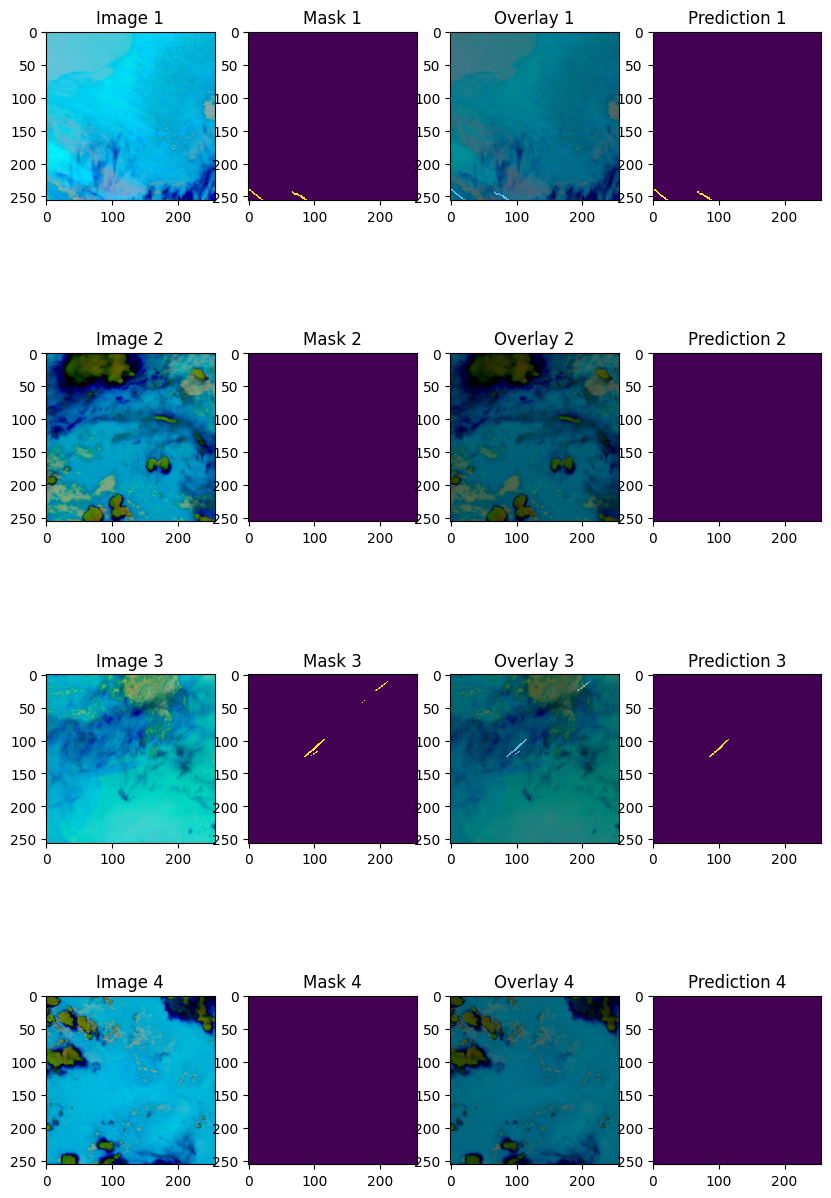

In [56]:
utils.plot_image_and_mask(sf_data, sf_targets, ens_pred>0.35)

In [38]:
def dice_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = 2.0 * intersection / (union + 1e-5)
    return dice.mean()

def iou_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = (preds + targets).sum(dim=(1, 2, 3)) - intersection
    iou = intersection / (union + 1e-5)
    return iou.mean()

In [40]:
# Initialize lists to store scores
dice_scores = []
iou_scores = []

# Perform predictions and calculate scores
with torch.no_grad():
    for (sf_data_batch, mf_data_batch) in zip(sf_test_dataloader, mf_test_dataloader):
        sf_data, targets = sf_data_batch
        mf_data, _ = mf_data_batch
        
        sf_data = sf_data.to(config.DEVICE)
        mf_data = mf_data.to(config.DEVICE)
        targets = targets.to(config.DEVICE)
        
        # Get predictions from the ensemble model
        predictions = torch.sigmoid(ensemble_model(sf_data, mf_data))

        # Calculate Dice and IoU scores
        dice = dice_score(predictions, targets)
        iou = iou_score(predictions, targets)

        # Store the scores
        dice_scores.append(dice.item())
        iou_scores.append(iou.item())

# Calculate the mean score across the dataset
mean_dice_score = sum(dice_scores) / len(dice_scores)
mean_iou_score = sum(iou_scores) / len(iou_scores)

print(f'Mean Dice Score: {mean_dice_score:.4f}')
print(f'Mean IoU Score: {mean_iou_score:.4f}')

KeyboardInterrupt: 